# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [166]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [167]:
import os
os.chdir('C:/Sereda/Lectures/Springboard/15.Unsupervised_Learning/15.6.3 Case Study - Customer Segmentation using Clustering_K-means')

In [168]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [169]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
print("Offers: ",df_offers.shape[0])
df_offers

Offers:  32


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
5,6,March,Prosecco,144,86,Chile,False
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
8,9,April,Chardonnay,144,57,Chile,False
9,10,April,Prosecco,72,52,California,False


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [170]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
print("Transactions: ",df_transactions.shape[0])
df_transactions.head()

Transactions:  324


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [171]:
df = df_offers.merge(df_transactions, how='outer', on='offer_id')
print(df.shape)
df.head()

(324, 9)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   offer_id       324 non-null    int64 
 1   campaign       324 non-null    object
 2   varietal       324 non-null    object
 3   min_qty        324 non-null    int64 
 4   discount       324 non-null    int64 
 5   origin         324 non-null    object
 6   past_peak      324 non-null    bool  
 7   customer_name  324 non-null    object
 8   n              324 non-null    int64 
dtypes: bool(1), int64(4), object(4)
memory usage: 23.1+ KB


### pivot_table()

In [173]:
x_cols = pd.pivot_table(df, values='n', index='customer_name', columns=['offer_id'], fill_value=0)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print("Customers: ",len(x_cols))
x_cols

Customers:  100


offer_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
Barnes,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
Bell,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
Bennett,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
Brooks,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [174]:
df.loc[df['customer_name']=='Young'] # verification

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
45,6,March,Prosecco,144,86,Chile,False,Young,1
97,9,April,Chardonnay,144,57,Chile,False,Young,1
147,15,June,Cabernet Sauvignon,144,19,Italy,False,Young,1
198,22,August,Champagne,72,63,France,False,Young,1
307,31,December,Champagne,72,89,France,False,Young,1
320,32,December,Cabernet Sauvignon,72,45,Germany,True,Young,1


## 3. Modelling
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce three methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Lower values of SS indicate more compact clusters and thus represent better clusterings. 

SS = [252.17671809256657, 228.12605042016813, 214.50464092140922, 205.1189393939394, 196.27185672514625, 187.90820400359877, 176.61079149608562, 171.84761904761905, 165.19653679653683]


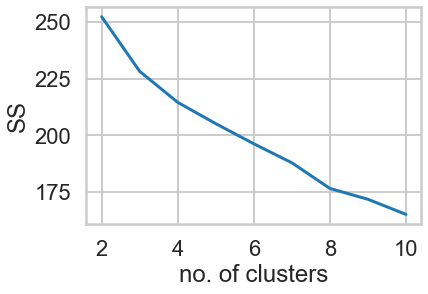

In [175]:
from sklearn.cluster import KMeans
SS = [] # sum-of-squares error
ks = np.arange(2,11)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(x_cols)
    SS.append(kmeans.inertia_)
print("SS =",SS)
plt.plot(ks, SS);
plt.xlabel('no. of clusters');
plt.ylabel('SS');

The problem is the monotonously decreasing character of SS with the absence of a clear "elbow", where the slope of SS would significantly decrease.
Since the largest change in slope occurs at 3 clusters, let us choose $k = 3$.

In [176]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(x_cols)
labels_kmeans = kmeans.labels_
print("Customers:",labels_kmeans.shape[0])
print("Cluster assignments:\n",labels_kmeans)

Customers: 100
Cluster assignments:
 [1 0 2 1 0 0 2 1 0 1 0 2 1 0 0 2 0 2 1 0 1 1 0 0 2 0 0 0 0 0 1 1 0 0 1 1 0
 1 0 1 2 2 1 0 1 0 1 1 0 0 0 0 0 2 0 1 2 1 1 0 0 1 0 1 1 0 2 0 0 0 0 0 0 1
 0 1 2 1 1 2 0 0 0 2 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0]


[51, 35, 14]


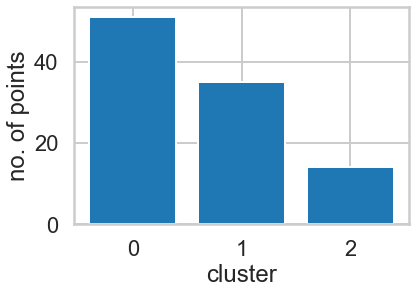

In [177]:
npoints = []
for i in range(np.max(labels_kmeans)+1):
    npoints.append( (labels_kmeans == i).sum() )
print(npoints)
plt.bar(np.arange(np.max(labels_kmeans)+1), npoints);
plt.xlabel('cluster');
plt.ylabel('no. of points');

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [178]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

For n_clusters = 2 The average silhouette_score is : 0.08911656187360473
For n_clusters = 3 The average silhouette_score is : 0.11015391298263667
For n_clusters = 4 The average silhouette_score is : 0.12941883590155936
For n_clusters = 5 The average silhouette_score is : 0.13911006290392372
For n_clusters = 6 The average silhouette_score is : 0.10979895247757922
For n_clusters = 7 The average silhouette_score is : 0.11326943929616652
For n_clusters = 8 The average silhouette_score is : 0.13198496281110994
For n_clusters = 9 The average silhouette_score is : 0.1291115731137975
For n_clusters = 10 The average silhouette_score is : 0.1216086963107709


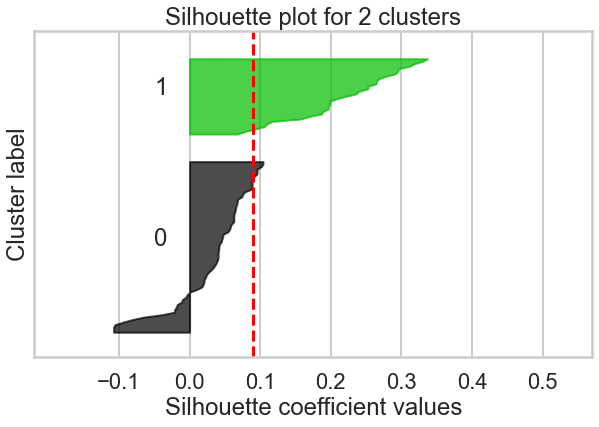

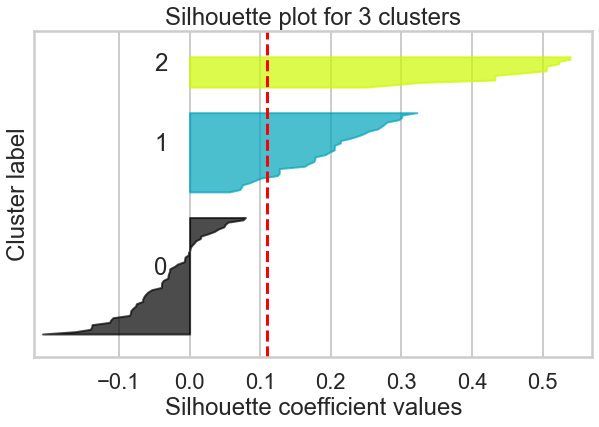

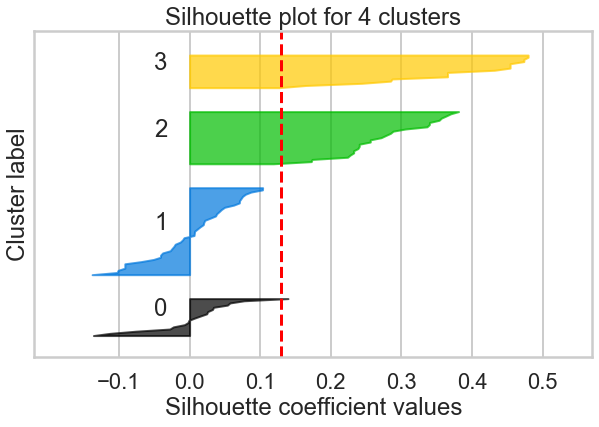

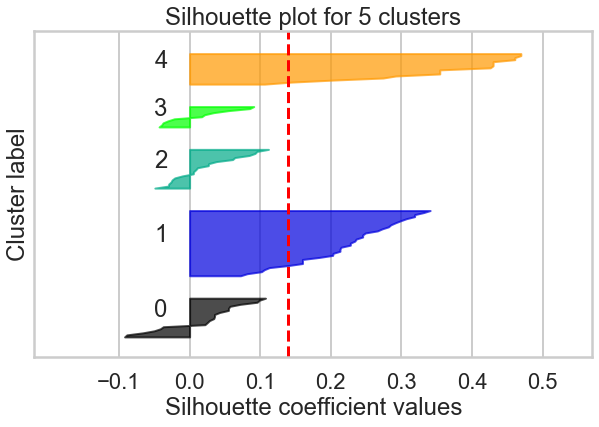

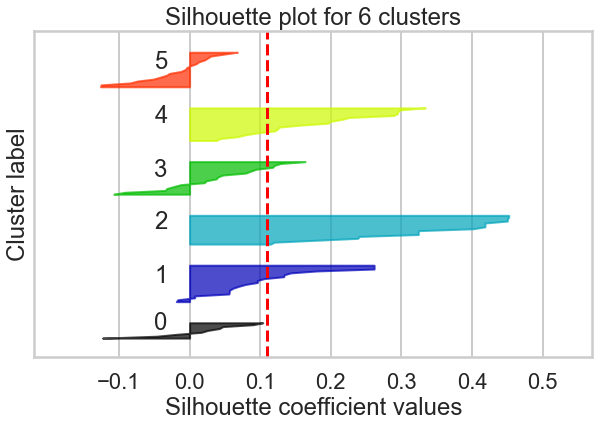

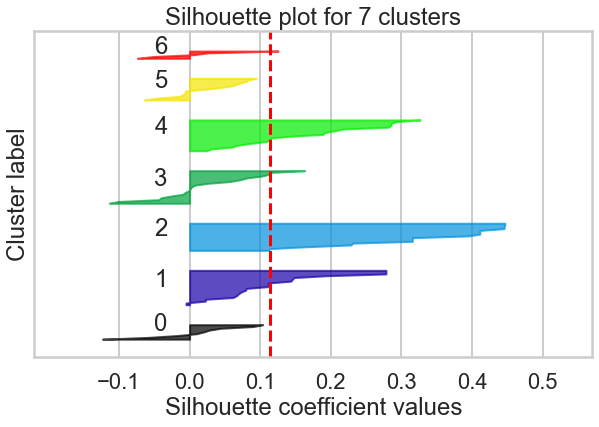

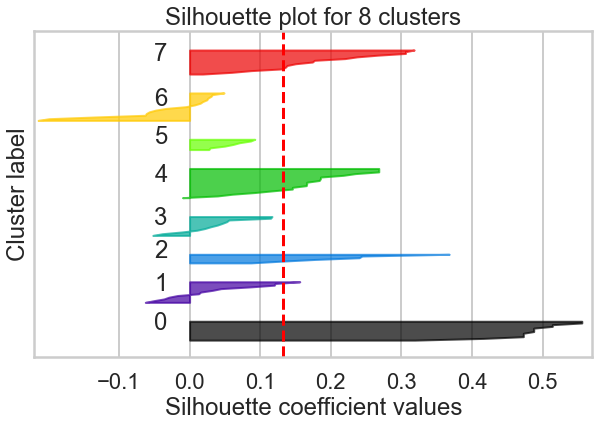

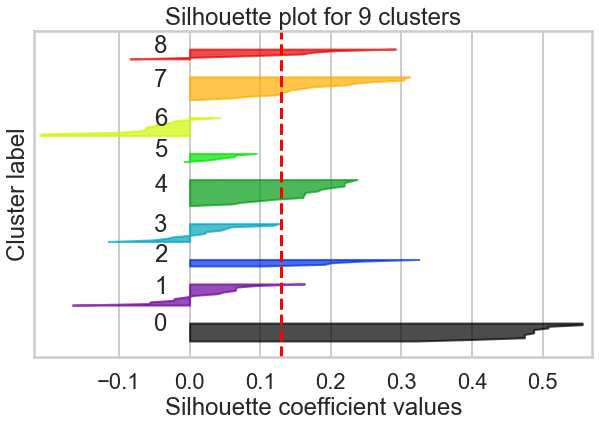

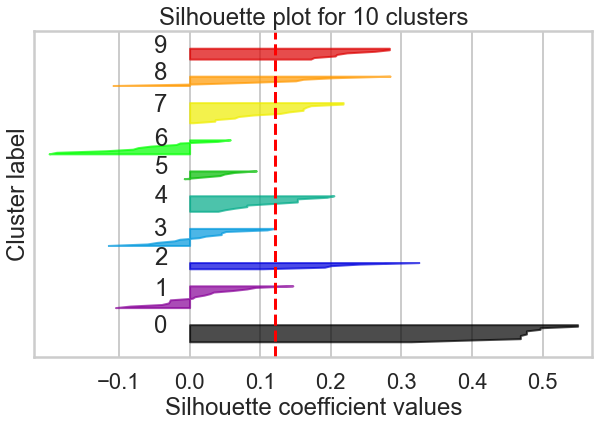

In [179]:
silhouette_score_kmeans = []
for k in ks:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 6)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1 to 1 but in this example all lie within [-0.15, 0.55]
    ax.set_xlim([-0.22, 0.57])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(x_cols) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_score_kmeans.append(silhouette_avg)
    print(
        "For n_clusters =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette plot for "+str(k)+" clusters")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])

plt.show()

Silhouette scores = 
 [0.08911656187360473, 0.11015391298263667, 0.12941883590155936, 0.13911006290392372, 0.10979895247757922, 0.11326943929616652, 0.13198496281110994, 0.1291115731137975, 0.1216086963107709]


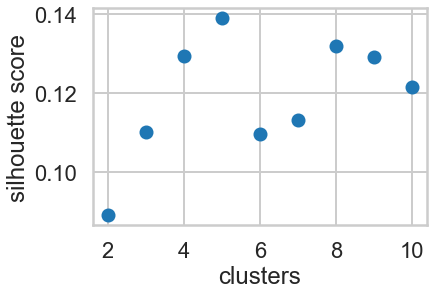

In [180]:
print("Silhouette scores = \n",silhouette_score_kmeans)
plt.scatter(ks, silhouette_score_kmeans);
plt.xlabel('clusters');
plt.ylabel('silhouette score');

The average silhouette score has a maximum 0.139 at $k=5$, suggesting 5 clusters, which is different from the Elbow method. Since the score is below 0.25, no substantial structure has been found. 

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words, a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

(100, 2)


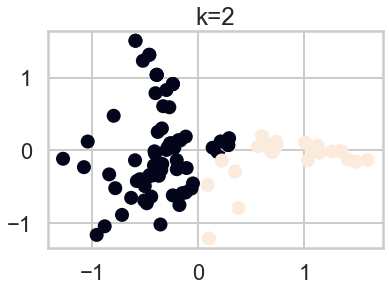

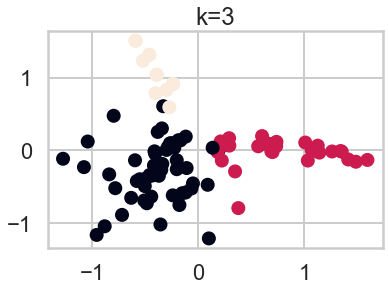

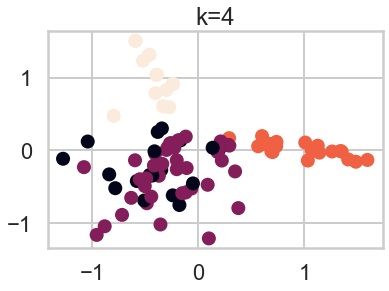

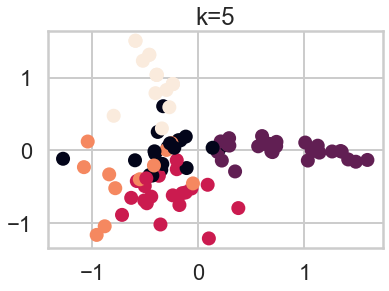

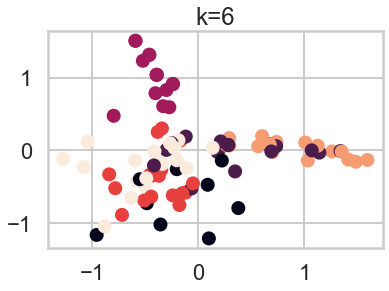

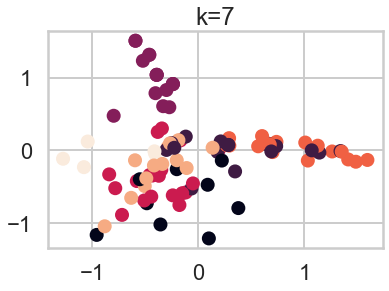

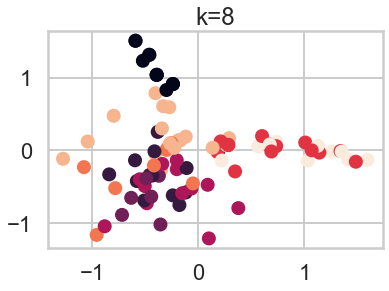

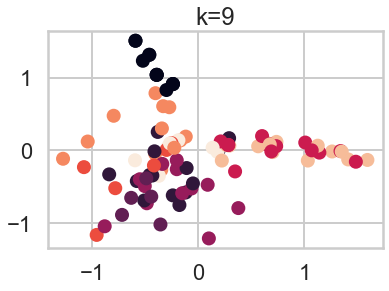

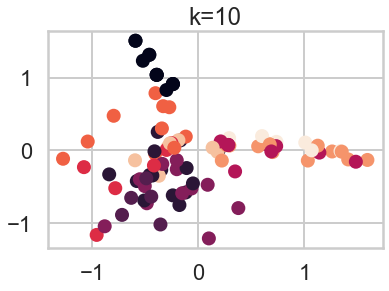

In [181]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(x_cols)
print(pca_features.shape)
for k in ks:
    #print("k="+str(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(x_cols)
    labels = kmeans.predict(x_cols)
    x = pca_features[:,0]
    y = pca_features[:,1]
    df_kmeans = pd.DataFrame({'customer_name':np.array(x_cols.index), 'label':labels, 'PC1':x, 'PC2':y})
    #print(df_kmeans.head())
    plt.figure()
    plt.scatter(x, y, c=labels);
    plt.title("k="+str(k))
    plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

The PCA components for each of the 100 customers, shown above, are colored according to the cluster assignments for k from 2 to 10 clusters. While some clusters are elongated and capture the directions of maximal variations, the other clusters are still scattered, and there is some overlap between clusters but, overall, there is a good separation of clusters for 2 to 3 clusters in the 2D space of two largest principal components. Based on these scatterplots, we would choose $k=3$ clusters. Therefore, the Elbow method of choosing $k$ is the best in this case. However, it would be worth looking at 3D space of 3 principal components to see if $k>3$ would be a better option.

### What do the clusters correspond to?
Let's looks at the differences between our 3 clusters.

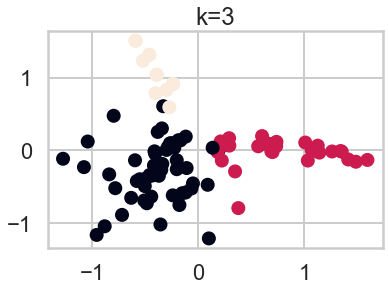

               label       PC1       PC2
customer_name                           
Adams              1  1.007580  0.108215
Allen              0 -0.287539  0.044715
Anderson           2 -0.392032  1.038391
Bailey             1  0.699477 -0.022542
Baker              0  0.088183 -0.471695
Barnes             0 -0.485282 -0.725503
Bell               2 -0.591941  1.506500
Bennett            1  0.661732  0.090308
Brooks             0 -0.118943 -0.577499
Brown              1  1.079827 -0.007488
Butler             0 -0.240431 -0.617026
Campbell           2 -0.522247  1.231406
Carter             1  1.260763 -0.014255
Clark              0 -0.579221 -0.420475
Collins            0  0.193998  0.010306
Cook               2 -0.392032  1.038391
Cooper             0 -0.406276 -0.045771
Cox                2 -0.591941  1.506500
Cruz               1  0.736155  0.117752
Davis              0 -0.349057 -0.267081
Diaz               1  1.412247 -0.123874
Edwards            1  0.181048 -0.020653
Evans           

In [182]:
k = 3 # optimal no. of clusters
x = pca_features[:,0]
y = pca_features[:,1]
df_kmeans = pd.DataFrame({'customer_name':np.array(x_cols.index), 'label':labels_kmeans, 'PC1':x, 'PC2':y})
df_kmeans.set_index('customer_name', drop=True, append=False, inplace=True)
plt.figure()
plt.scatter(x, y, c=labels_kmeans);
plt.title("k="+str(k))
plt.show()
print(df_kmeans)

In [183]:
df_clusters = df.merge(df_kmeans, how='left', on='customer_name').sort_values(by='label') #.reset_index(drop=True)
print(df_clusters.shape)
df_clusters

(324, 12)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,label,PC1,PC2
0,1,January,Malbec,72,56,France,False,Thomas,1,0,-1.041879,0.122314
177,19,July,Champagne,12,66,Germany,False,Nguyen,1,0,-0.202845,-0.257617
179,19,July,Champagne,12,66,Germany,False,Morales,1,0,0.099501,-1.208376
180,20,August,Cabernet Sauvignon,72,82,Italy,False,Sanchez,1,0,-1.077511,-0.229397
181,20,August,Cabernet Sauvignon,72,82,Italy,False,Parker,1,0,-0.110035,-0.241833
182,20,August,Cabernet Sauvignon,72,82,Italy,False,Cooper,1,0,-0.406276,-0.045771
183,20,August,Cabernet Sauvignon,72,82,Italy,False,Gomez,1,0,-0.412830,-0.012199
184,20,August,Cabernet Sauvignon,72,82,Italy,False,Kelly,1,0,-0.504329,-0.489361
185,20,August,Cabernet Sauvignon,72,82,Italy,False,Sanders,1,0,-1.274329,-0.114296
186,21,August,Champagne,12,50,California,False,Wright,1,0,-0.489805,-0.383307


Look at each cluster in detail

In [184]:
cluster0 = df_clusters[df_clusters['label'] == 0].drop(['PC1','PC2'], axis=1)
cluster1 = df_clusters[df_clusters['label'] == 1].drop(['PC1','PC2'], axis=1)
cluster2 = df_clusters[df_clusters['label'] == 2].drop(['PC1','PC2'], axis=1)

#### Kind of wine `varietal`

In [185]:
print(df_clusters.varietal.unique())
len(df_clusters.varietal.unique())

['Malbec' 'Champagne' 'Cabernet Sauvignon' 'Merlot' 'Prosecco'
 'Pinot Grigio' 'Chardonnay' 'Pinot Noir' 'Espumante']


9

In [186]:
def plot3cluster(v):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(18, 5)
    ax[0].hist(cluster0[v]); #,color=['red']*len(cluster0)
    ax[0].tick_params(labelrotation=90)
    ax[1].hist(cluster1[v]);
    ax[1].tick_params(labelrotation=90)
    ax[2].hist(cluster2[v]);
    ax[2].tick_params(labelrotation=90)

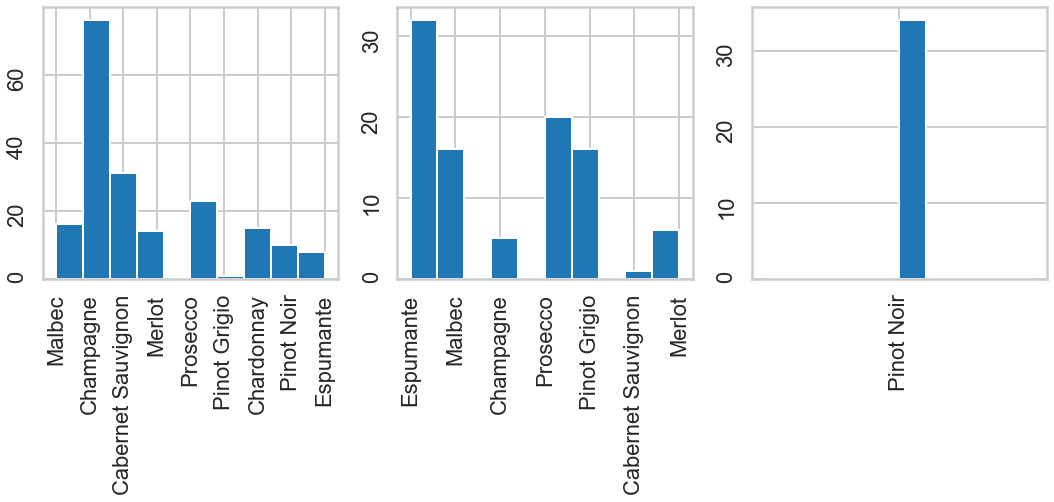

In [26]:
plot3cluster('varietal')

The largest `cluster0` has each of the 9 kinds of wine, mid-size `cluster1` has two kinds missing: 'Chardonnay' and 'Pinot Noir', and the smallest `cluster2` contains only 'Pinot Noir' wine. `cluster0` has only 10 orders of this wine within 2 offers:

In [23]:
print(cluster0.loc[cluster0.varietal=='Pinot Noir'])

     offer_id campaign    varietal  min_qty  discount     origin  past_peak  \
237        26  October  Pinot Noir      144        83  Australia      False   
242        26  October  Pinot Noir      144        83  Australia      False   
245        26  October  Pinot Noir      144        83  Australia      False   
246        26  October  Pinot Noir      144        83  Australia      False   
238        26  October  Pinot Noir      144        83  Australia      False   
12          2  January  Pinot Noir       72        17     France      False   
13          2  January  Pinot Noir       72        17     France      False   
15          2  January  Pinot Noir       72        17     France      False   
16          2  January  Pinot Noir       72        17     France      False   
19          2  January  Pinot Noir       72        17     France      False   

    customer_name  n  label  
237        Thomas  1      0  
242      Peterson  1      0  
245          Gray  1      0  
246       

`cluster0` and `cluster1` have a strong difference in the proportions of wine kinds. In particular, 'Champagne' and 'Cabernet Sauvignon' that are mostly in `cluster0`, while 'Espumante' and 'Pinot Grigio' are mostly in `cluster1`.

#### `min_qty`

In [187]:
print(np.sort(df_clusters.min_qty.unique()))

[  6  12  72 144]


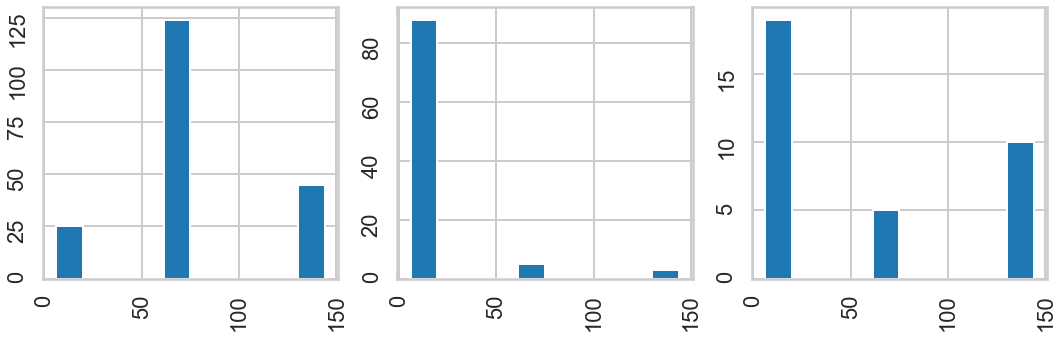

In [25]:
plot3cluster('min_qty')

`cluster0` is dominated by `min_qty`=72, while the other two clusters mostly have small `min_qty`=6.

#### `discount`

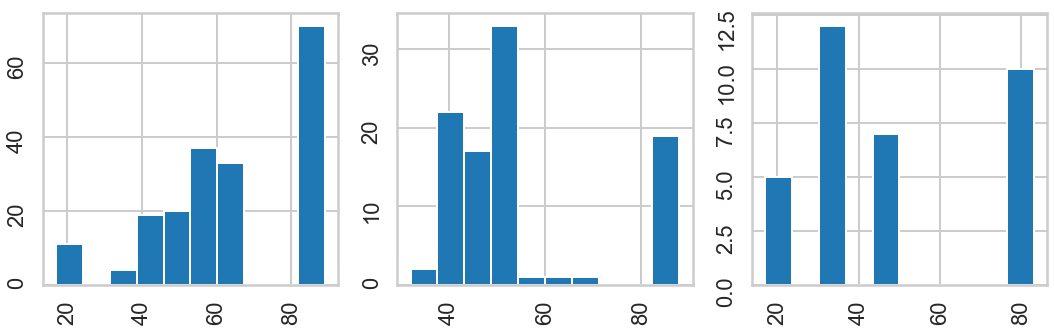

In [26]:
plot3cluster('discount')

There are quite distinct distributions of the discount in the clusters.

#### `origin`

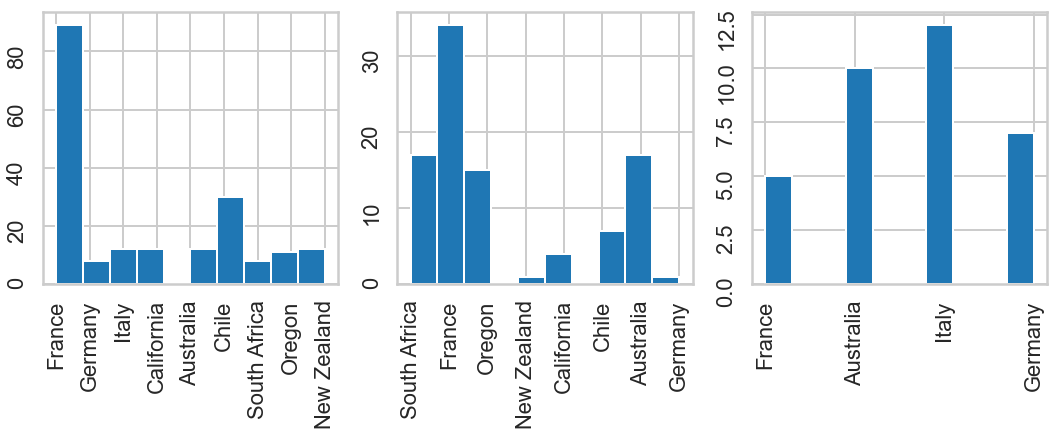

In [26]:
plot3cluster('origin')

`cluster0` and `cluster1` are dominated by the wine from France, while the mode in `cluster2` is Italy.

#### `past_peak`

`cluster2` has all `past_peak`=False.

In [188]:
print(df_clusters[df_clusters['label'] == 2].past_peak.unique())

[False]


#### Pairs of features
Now consider how pairs of features differ between clusters.

In [189]:
df2 = df.merge(df_kmeans, how='left', on='customer_name')
df2.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,label,PC1,PC2
0,1,January,Malbec,72,56,France,False,Thomas,1,0,-1.041879,0.122314
1,1,January,Malbec,72,56,France,False,Jackson,1,0,-0.839578,-0.328823
2,1,January,Malbec,72,56,France,False,Mitchell,1,0,-0.342938,0.302186
3,1,January,Malbec,72,56,France,False,Peterson,1,0,-0.797379,0.475995
4,1,January,Malbec,72,56,France,False,Wood,1,0,-0.551215,-0.395670


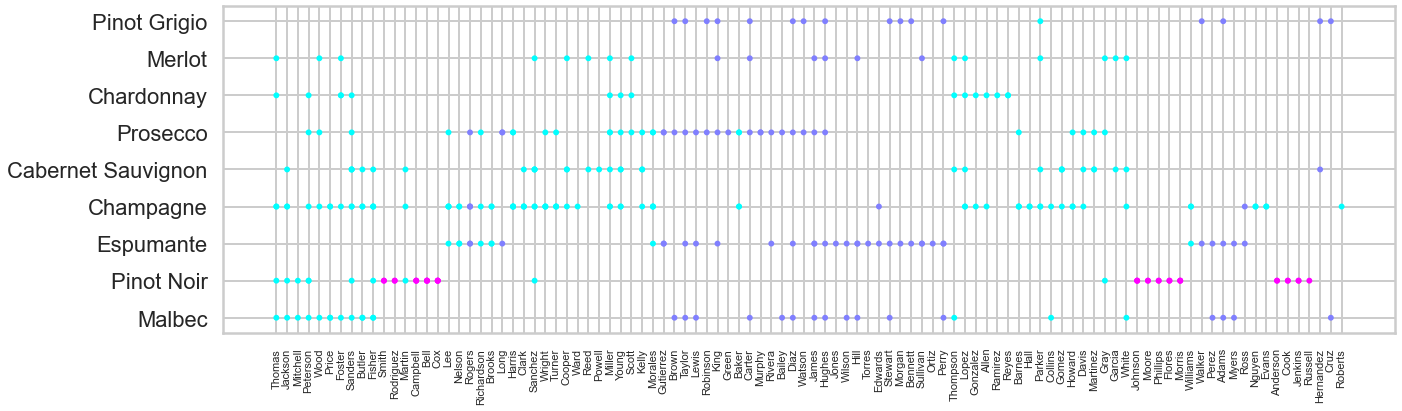

In [190]:
fig, axs = plt.subplots(figsize = (21,6))
plt.scatter(df2.customer_name,df2.varietal, s=15, c=df2.label, cmap='cool');
plt.xticks(rotation = 90, size = 11);

### Multi-feature decision tree by visual inspection
As we already know, the smallest cluster of 34 transactions (<i>magenta</i>) has only 'Pinot Noir' wine. Since the same customer can have several orders of the same kind of wine, some points from the same cluster may overlap. But, since each customer belongs to only one cluster, there is no overlap of points from different clusters. The mid-size cluster with 96 transactions (<i>blue</i>) does not have 'Chardonnay' and 'Pinot Noir' wines. Customers who ordered 'Malbec' but did not order 'Champagne' are also in this cluster. Customers who ordered both 'Malbec' and 'Champagne' are in the largest cluster with 194 transactions. Those who purchased 'Pinot Grigio' without buying 'Champagne' are in the mid-size cluster; all others who bought 'Pinot Grigio' or 'Cabernet Sauvignon', or only 'Champagne' are in the largest cluster. If bought 'Espumante' and did not buy 'Champagne', then mid-size cluster. Of the rest, if ordered both 'Prosecco' and 'Champagne' without ordering 'Espumante', then in the largest cluster. 'Prosecco' without 'Champagne' and without 'Espumante' belongs to mid-size cluster. The remaining 9 customers (Lee, Nilson, Rogers, Richardson, Brooks, Morales, Lowaros, Williams, and Ross) are indistinguishable if using only the sets of the wine kinds within the above decision tree.

<font color=red><b>Q1 It seems that a decision tree can help see difference between clusters? Is it worth trying here?</b></font>

In [ ]:
# Tested all pairs of variables here
plt.scatter(df2.offer_id, df2.past_peak, c=df2.label, s=15);

Indeed, the clusters differ mainly in the varieties of wines.

### Decision tree
Let's try to find out a small set of decisions which would give the above 3 clusters.

In [191]:
df_tree = df2[['varietal','label']] #x_cols
df_tree.head()

,varietal,label
0,Malbec,0
1,Malbec,0
2,Malbec,0
3,Malbec,0
4,Malbec,0


In [192]:
from sklearn import tree, metrics
tree_entropy = tree.DecisionTreeClassifier(criterion = "entropy")
# All data as training data
X_train = x_cols
y_train = df_kmeans['label']
tree_entropy.fit(X_train, y_train) # fit the tree model
y_pred = tree_entropy.predict(X_train) # using all data as the test set
np.sum(y_pred == y_train) # 100 - all predictions are correct, thus we know the complete decision tree

100

<font color=red><b>Q2 How to modify the metrics evaluation below (based on binary classification sample) for multi-class classification?</b></font>

In [207]:
# model evaluation metrics
print("Model Entropy - no max depth")
y_test = y_train
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_pred, pos_label = "Yes", average=None))
print('Precision score for "No"' , metrics.precision_score(y_test,y_pred, pos_label = "No", average=None))
print('Recall score for "Yes"' , metrics.recall_score(y_test,y_pred, pos_label = "Yes", average=None))
print('Recall score for "No"' , metrics.recall_score(y_test,y_pred, pos_label = "No", average=None))

Model Entropy - no max depth
Accuracy: 1.0
Balanced accuracy: 1.0
Precision score for "Yes" [1. 1. 1.]
Precision score for "No" [1. 1. 1.]
Recall score for "Yes" [1. 1. 1.]
Recall score for "No" [1. 1. 1.]


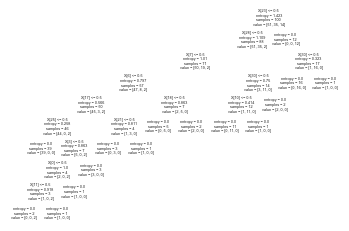

In [193]:
# Visualize the tree
tree.plot_tree(tree_entropy)
import graphviz
int2str = lambda x : str(x)
dot_data = tree.export_graphviz(tree_entropy, out_file=None, class_names=tree_entropy.classes_.astype('str').tolist(), filled=True)
graph = graphviz.Source(dot_data)
graph.render("Clustering_customers_wine");

In [194]:
from IPython.display import IFrame
#IFrame("C:/Sereda/Lectures/Springboard/15.Unsupervised_Learning/15.6.3 Case Study - Customer Segmentation using Clustering_K-means/Clustering_customers_wine.pdf", width=600, height=300)
IFrame("./Clustering_customers_wine.pdf", width=600, height=300)

<font color=red><b>Q3 need help displaying decision tree (trying to display image from PDF)</b></font>

In [212]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

In [218]:
PDF('Clustering_customers_wine.pdf',size=(300,250))

In [150]:
# Display image in PDF
#pip install wand

Note: you may need to restart the kernel to use updated packages.  Downloading Wand-0.6.7-py2.py3-none-any.whl (139 kB)



In [195]:
from wand.image import Image as WImage

ImportError: MagickWand shared library not found.
You probably had not installed ImageMagick library.
Try to install:
  https://docs.wand-py.org/en/latest/guide/install.html#install-imagemagick-on-windows

In [196]:
fig = Image(filename=('./Clustering_customers_wine.pdf'))
fig

NameError: name 'Image' is not defined

In [162]:
?tree.plot_tree

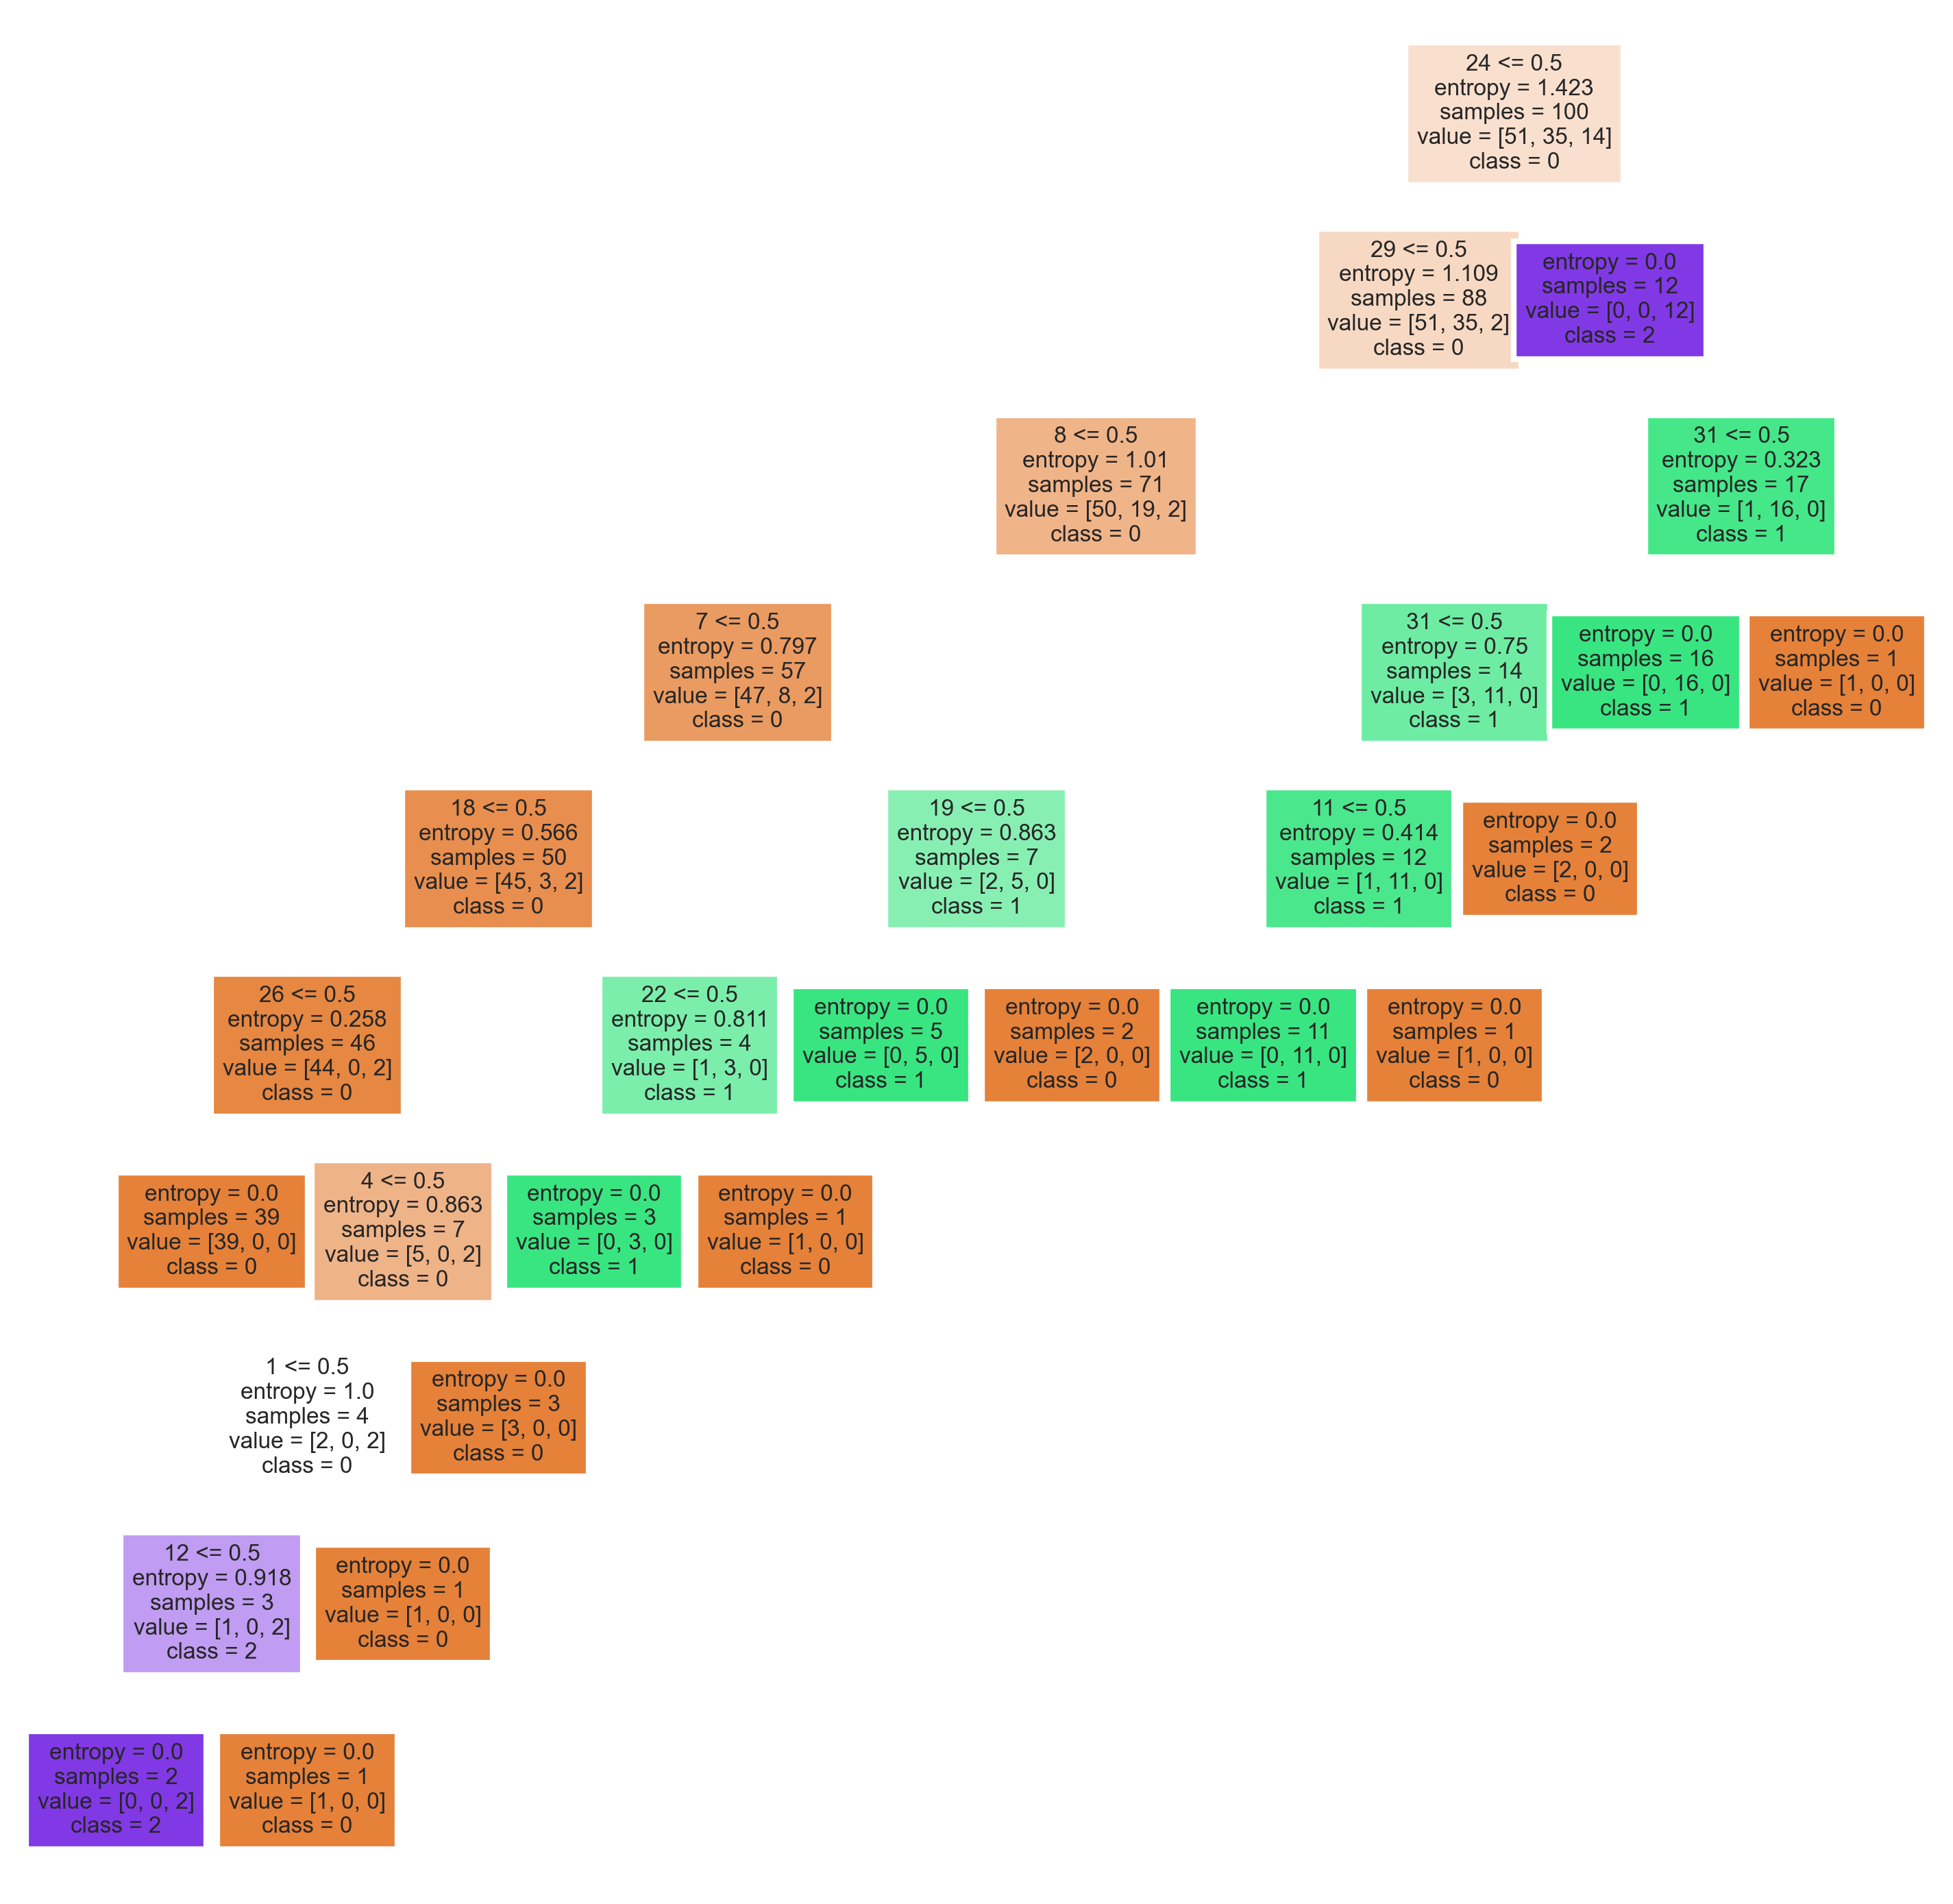

In [362]:
# Setting dpi = 300 to make image clearer than default
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
tree.plot_tree(tree_entropy, feature_names=list(np.array(x_cols.columns).astype('str')),
               class_names=tree_entropy.classes_.astype('str').tolist(), filled=True, fontsize=8);
# max_depth=9

The resulting tree uses only one feature in all decision, which makes the tree quite talls. First decision is made using feature `X[23]` (`offer_id = 24`). All customers who used this offer (`X[23] > 0.5`) are in class 2:

In [198]:
# Verify classification decision
y_train[x_cols.iloc[:,23]==1] # all X[23] > 0.5 cases

customer_name
Anderson    2
Bell        2
Campbell    2
Cook        2
Cox         2
Flores      2
Jenkins     2
Johnson     2
Moore       2
Morris      2
Phillips    2
Smith       2
Name: label, dtype: int32

#### gini criterion

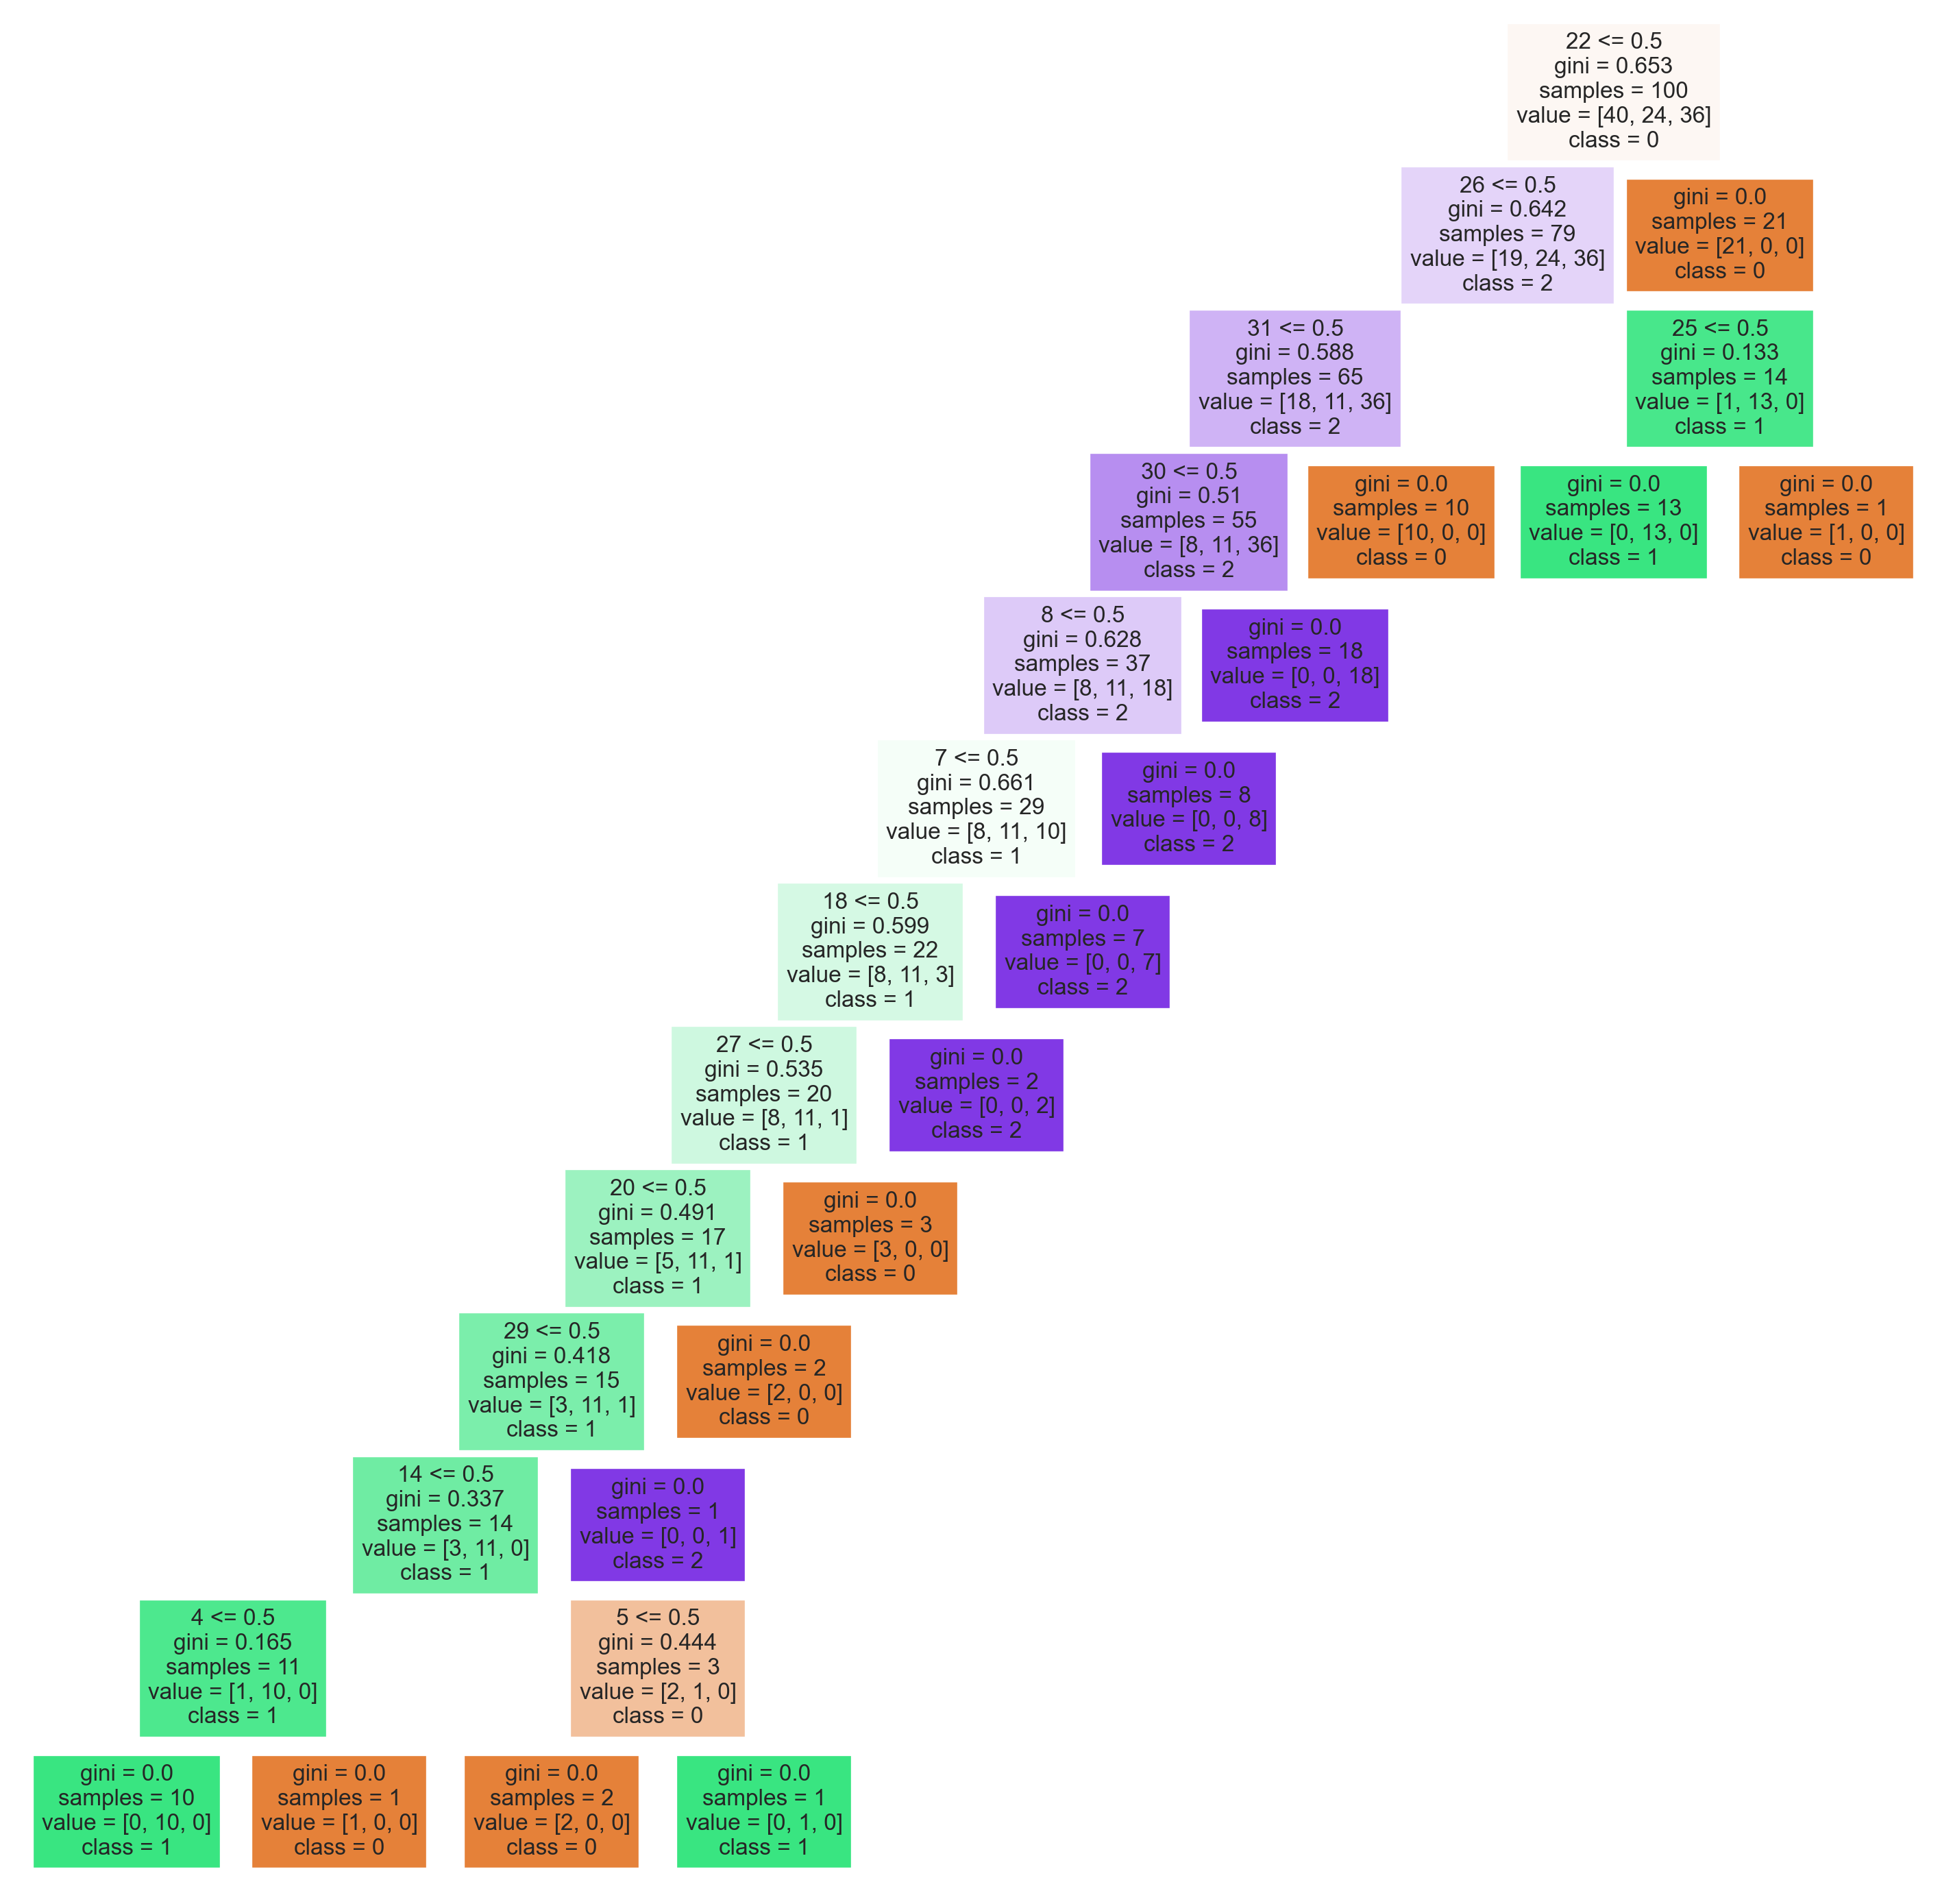

In [361]:
tree_gini = tree.DecisionTreeClassifier(criterion = "gini", random_state=0)
# All data as training data
#X_train = x_cols
#y_train = df_kmeans['label']
tree_gini.fit(X_train, y_train) # fit the tree model
y_pred = tree_gini.predict(X_train) # using all data as the test set
np.sum(y_pred == y_train) # 100 - all predictions are correct, thus we know the complete decision tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
tree.plot_tree(tree_gini, feature_names=list(np.array(x_cols.columns).astype('str')),
               class_names=tree_gini.classes_.astype('str').tolist(), filled=True, fontsize=8);
# max_depth=12

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, we restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

Explained variance =
 [0.4096489  0.30753551 0.2022926  0.16703717 0.15015248 0.1434373
 0.13818887 0.12192294 0.11636172 0.10804271 0.09937813 0.09495961
 0.08690352 0.07256738 0.0660996  0.06245473 0.05634388 0.05327395
 0.04728801 0.04393911 0.03900424 0.03625783 0.03455714 0.03235091
 0.02940632 0.02618221 0.02308167 0.02142632 0.018814   0.0165252
 0.01426187 0.0077789 ]


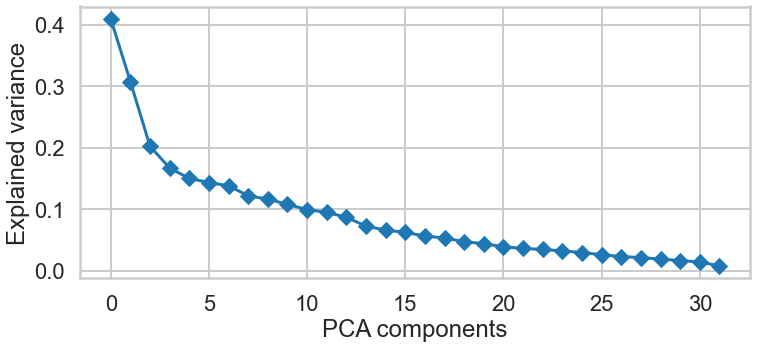

In [199]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
ev = pca.explained_variance_ # explained variance for each of the 32 offers
print("Explained variance =\n",ev)
#print("Cumulative explained variance =\n",np.cumsum(ev))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 5)
plt.plot(ev, marker='D');
plt.xlabel('PCA components');
plt.ylabel('Explained variance');

A sharp change in the slope of explained variance occurs at 3 dimensions. Therefore, adding 4th principal component allows to account for much less variation than addition of 3rd principal component, so that it would be best to use three PCA components for visualization of clusters.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

The Elbow method seems to be reliable in choosing the optimal number of clusters and number of PCA components.<br>
In this case study, the optimal number of clusters for the 100 customers who used one or more of the 32 offers of wines is 3. The optimal number of principal components is 3, so it would be best to use 3D plots to visualize separation between clusters.

<font color=red><b>Q4 What are the other results worth discussing here?
    
Q5 Would it make sense to try clustering manually based on wine kinds and calculate SS error to compare with KMeans, or to compare clustering methods using such error calculation?</b></font>

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


### Affinity Propagation
https://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html#sphx-glr-auto-examples-cluster-plot-affinity-propagation-py

Parameters:
* preference, which controls how many exemplars are used
* damping factor which damps the responsibility and availability messages to avoid numerical oscillations when updating these messages.

In [200]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

#### `preference` parameter optimization

C:\Programs\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
C:\Programs\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
C:\Programs\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "


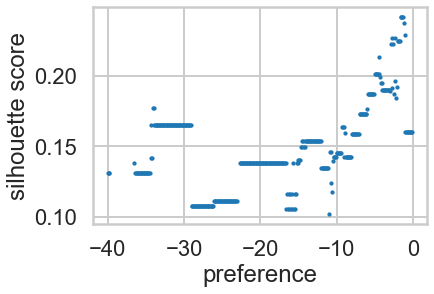

In [201]:
preference_aff = list([]) # 'preference' parameter values
silhouette_score_aff = list([])
cluster_n_aff = list([]) # no. of clusters
for preference in np.arange(-40, 1, 0.1):
    af = AffinityPropagation(preference=preference, random_state=0, max_iter=500).fit(x_cols)
    cluster_centers_indices = af.cluster_centers_indices_
    labels_aff = af.labels_
    n_clusters_ = len(cluster_centers_indices)
    if n_clusters_ > 1 and n_clusters_ < 100:
        preference_aff.append(preference)
        cluster_n_aff.append(n_clusters_)
        labels_aff_unique, labels_aff_count = np.unique(labels_aff, return_counts=True)
        silhouette_score_ = metrics.silhouette_score(x_cols, labels_aff, metric="sqeuclidean")
        silhouette_score_aff.append(silhouette_score_)
plt.scatter(preference_aff, silhouette_score_aff, s=5);
plt.xlabel("preference");
plt.ylabel("silhouette score");

There is a change in the behavior of silhouette score starting at `preference = -10`. At `preference > 10`, the number of clusters starts growing quickly up to the maximum of 100.

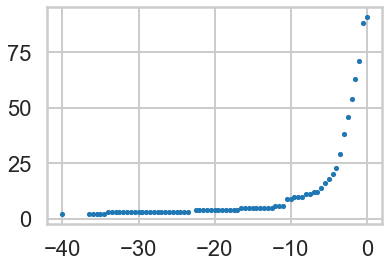

In [293]:
plt.scatter(preference_aff, cluster_n_aff, s=10);

Therefore, the optimal value is `preference = -34`.

In [296]:
af = AffinityPropagation(preference=-34, random_state=0).fit(x_cols)
cluster_centers_indices = af.cluster_centers_indices_
labels_aff = af.labels_
n_clusters_ = len(cluster_centers_indices)
labels_aff_unique, labels_aff_count = np.unique(labels_aff, return_counts=True)
print("Labels and counts:\n", np.asarray((labels_aff_unique, labels_aff_count)).T) 
print("Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_kmeans, labels_aff))
print("Completeness: %0.3f" % metrics.completeness_score(labels_kmeans, labels_aff))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_kmeans, labels_aff))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_kmeans, labels_aff))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_kmeans, labels_aff))
print("Silhouette Coefficient: %0.3f" 
      % metrics.silhouette_score(x_cols, labels_aff, metric="sqeuclidean"))

Labels and counts:
 [[ 0 19]
 [ 1 27]
 [ 2 54]]
Estimated number of clusters: 3
Homogeneity: 0.484
Completeness: 0.476
V-measure: 0.480
Adjusted Rand Index: 0.434
Adjusted Mutual Information: 0.469
Silhouette Coefficient: 0.177


After adjustment of `preference` parameter in the Affinity Propagation clustering, its silhouette coefficient 0.177 is considerably higher than in KMeans (maximum 0.139 for $k=5$, and 0.110 for $k=3$). Optimal number of 3 clusters coincides with the Elbow method in KMeans clustering.

Clusters are quite well separated in 2D space of two main PCA components,

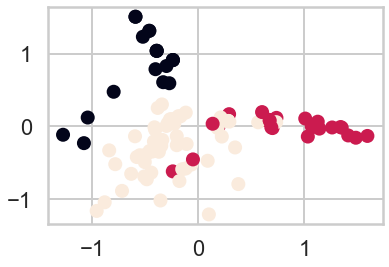

In [250]:
plt.scatter(df_kmeans.PC1, df_kmeans.PC2, c=labels_aff);

unlike for some random values of the parameter, e.g. see plot below for `preference=-40`:

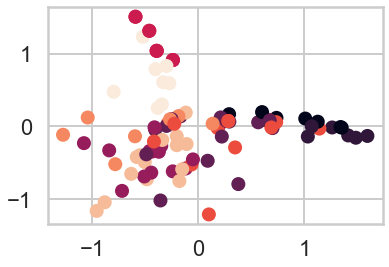

In [176]:
plt.scatter(df_kmeans.PC1, df_kmeans.PC2, c=labels_aff); # do not execute! Would have to re-run AffinityPropagation

#### PCA 3 components
Let's use 3 principal components to better visualize separation of clusters.

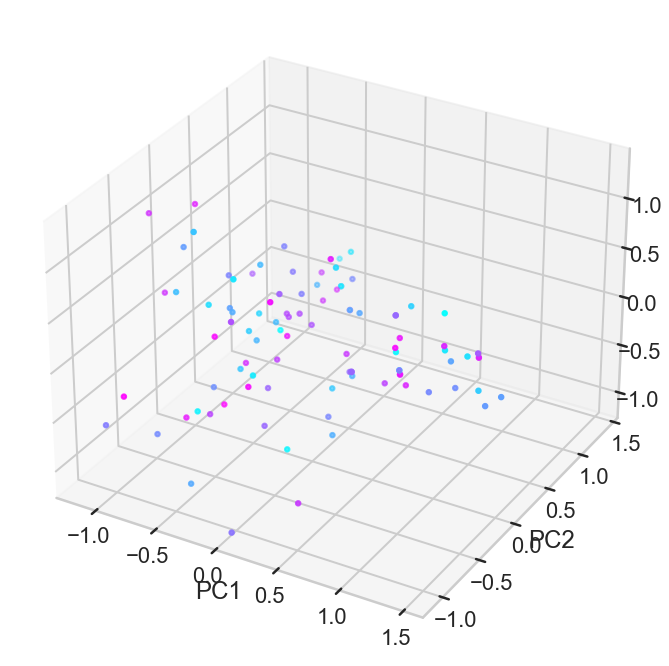

In [209]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_features = pca.fit_transform(x_cols)
#print(pca_features.shape)
k=3
kmeans = KMeans(n_clusters=k, random_state=0).fit(x_cols)
labels = kmeans.predict(x_cols)
x = pca_features[:,0]
y = pca_features[:,1]
z = pca_features[:,2]
df_kmeans_pca3 = pd.DataFrame({'customer_name':np.array(x_cols.index), 'label':labels, 'PC1':x, 'PC2':y, 'PC3':z})
# 3D plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, c=labels_aff, cmap='cool')
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.set_xlim([np.min(x), np.max(x)])
ax.set_ylim([np.min(y), np.max(y)])
plt.show()

#### `damping` parameter optimization
Damping factor (between 0.5 and 1) is the extent to which the current value is maintained relative to incoming values (weighted 1 - damping).

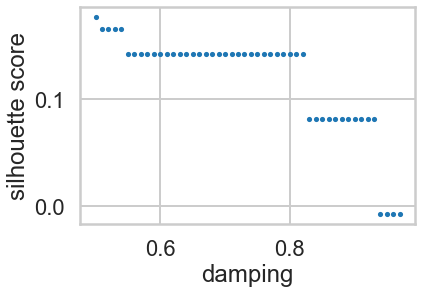

In [210]:
damping_aff = list([]) # 'preference' parameter values
silhouette_score_aff = list([])
cluster_n_aff = list([]) # no. of clusters
preference = -34 # previously optimized
for damping in np.arange(0.5, 1, 0.01):
    af = AffinityPropagation(damping = damping, preference=preference, max_iter=500, random_state=0).fit(x_cols)
    cluster_centers_indices = af.cluster_centers_indices_
    labels_aff = af.labels_
    n_clusters_ = len(cluster_centers_indices)
    if n_clusters_ > 1 and n_clusters_ < 100:
        damping_aff.append(damping)
        cluster_n_aff.append(n_clusters_)
        labels_aff_unique, labels_aff_count = np.unique(labels_aff, return_counts=True)
        silhouette_score_ = metrics.silhouette_score(x_cols, labels_aff, metric="sqeuclidean")
        silhouette_score_aff.append(silhouette_score_)
plt.scatter(damping_aff, silhouette_score_aff, s=10);
plt.xlabel("damping");
plt.ylabel("silhouette score");

In [211]:
silhouette_score_aff[0]

0.17702008215489098

In [284]:
?AffinityPropagation

If the preferences are not passed as arguments, they will be set to the median of the input similarities.

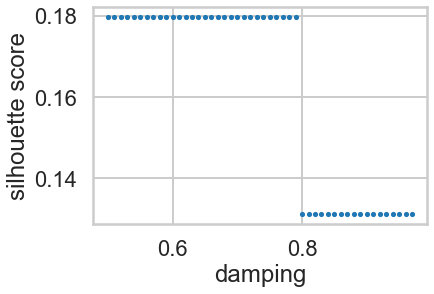

In [300]:
damping_aff = list([]) # 'preference' parameter values
silhouette_score_aff = list([])
cluster_n_aff = list([]) # no. of clusters
preference = -34 # previously optimized
for damping in np.arange(0.5, 1, 0.01):
    af = AffinityPropagation(damping = damping, max_iter=500, random_state=0).fit(x_cols)
    cluster_centers_indices = af.cluster_centers_indices_
    labels_aff = af.labels_
    n_clusters_ = len(cluster_centers_indices)
    if n_clusters_ > 1 and n_clusters_ < 100:
        damping_aff.append(damping)
        cluster_n_aff.append(n_clusters_)
        labels_aff_unique, labels_aff_count = np.unique(labels_aff, return_counts=True)
        silhouette_score_ = metrics.silhouette_score(x_cols, labels_aff, metric="sqeuclidean")
        silhouette_score_aff.append(silhouette_score_)
plt.scatter(damping_aff, silhouette_score_aff, s=10);
plt.xlabel("damping");
plt.ylabel("silhouette score");

In [301]:
silhouette_score_aff[0]

0.17978337664151187

This approach gives slightly higher silhouette score.

<font color=red><b>Q6 Is there a way to retrieve the preference value?</b></font>

### Spectral clustering
https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering

The present version of SpectralClustering requires the number of clusters to be specified in advance. It works well for a small number of clusters, but is not advised for many clusters.
`amg` solver requires that the `pyamg` module is installed.

#### Similarity matrix for customers

In [288]:
nc = X_train.shape[0] # no. of customers
nf = X_train.shape[1] # no. of features
sim=np.empty([nc,nc], dtype=int) # similarity matrix: no. of coinciding features
for i in range(nc):
    sim[i,i] = nf
    for j in range(i+1,nc):
        sim[i,j] = np.sum(x_cols.iloc[i] == x_cols.iloc[j])
        sim[j,i] = sim[i,j]
sim

array([[32, 27, 27, ..., 25, 25, 23],
       [27, 32, 28, ..., 26, 28, 26],
       [27, 28, 32, ..., 26, 26, 24],
       ...,
       [25, 26, 26, ..., 32, 24, 24],
       [25, 28, 26, ..., 24, 32, 24],
       [23, 26, 24, ..., 24, 24, 32]])

In [297]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=3, affinity='precomputed', n_init=10, assign_labels='discretize')
labels_spectral = sc.fit_predict(sim)
print(labels_spectral)

[2 0 1 2 0 0 1 2 0 2 0 1 2 0 2 1 0 1 2 0 2 2 0 0 1 0 0 0 0 1 2 2 0 0 2 2 0
 2 0 2 1 1 2 0 2 0 2 2 0 1 1 0 1 1 0 2 1 2 2 0 0 2 0 2 2 1 1 1 0 1 1 1 0 2
 0 2 1 0 2 1 0 0 0 1 2 2 2 1 2 2 0 2 0 2 0 0 2 0 0 0]


In [298]:
tree_entropy_spectral = tree.DecisionTreeClassifier(criterion = "entropy")
# All data as training data
#X_train = x_cols
#y_train = labels_spectral
tree_entropy_spectral.fit(X_train, y_train) # fit the tree model
y_pred = tree_entropy_spectral.predict(X_train) # using all data as the test set
np.sum(y_pred == y_train) # 100 - all predictions are correct, thus we know the complete decision tree

100

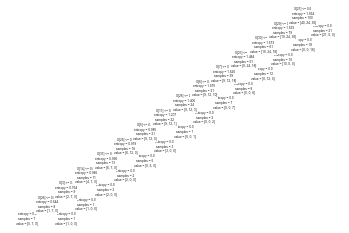

In [301]:
# Visualize the tree
tree.plot_tree(tree_entropy_spectral)
dot_data = tree.export_graphviz(tree_entropy_spectral, out_file=None, class_names=tree_entropy_spectral.classes_.astype('str').tolist(), filled=True)
graph = graphviz.Source(dot_data)
graph.render("Clustering_customers_wine.Spectral");

Tree depth is 14 - too many questions! Let's try to decrease it.

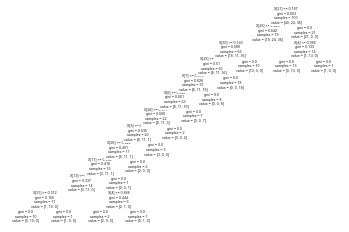

In [356]:
tree_entropy_spectral = tree.DecisionTreeClassifier(criterion = "gini", splitter = "random", min_samples_leaf = 1, random_state=0 )
# All data as training data
#X_train = x_cols
#y_train = labels_spectral
tree_entropy_spectral.fit(X_train, y_train) # fit the tree model
y_pred = tree_entropy_spectral.predict(X_train) # using all data as the test set
np.sum(y_pred == y_train) # 100 - all predictions are correct, thus we know the complete decision tree
tree.plot_tree(tree_entropy_spectral)
dot_data = tree.export_graphviz(tree_entropy_spectral, out_file=None, class_names=tree_entropy_spectral.classes_.astype('str').tolist(), filled=True)
graph = graphviz.Source(dot_data)
graph.render("Clustering_customers_wine.Spectral"); # max_depth=12

`criterion = "gini"` helped decrease the tree depth, contrary to the clustering from KMeans.

### Agglomerative clustering
https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

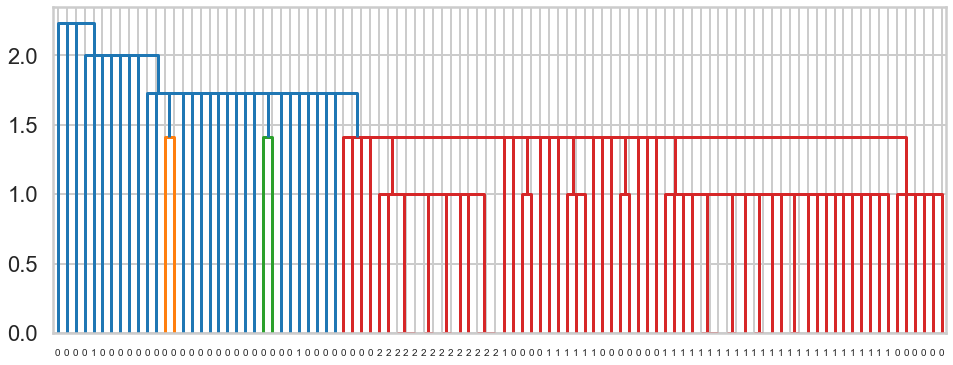

In [369]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
# Calculate the linkage
mergings = linkage(x_cols, method='single')
# Plot the dendrogram, using labels_kmeans as labels
f, ax = plt.subplots(figsize=(16,6))
dendrogram(mergings,
           labels=labels_kmeans,
           leaf_rotation=0, leaf_font_size=10)
plt.show()

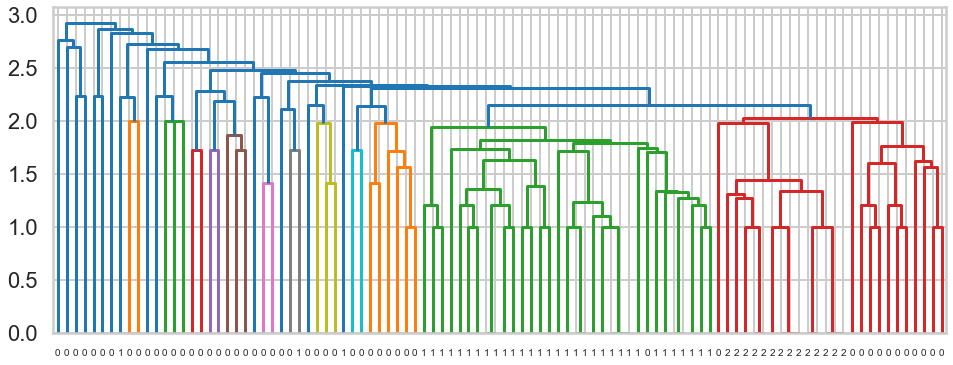

In [371]:
mergings = linkage(x_cols, method='average') #complete
# Plot the dendrogram, using labels_kmeans as labels
f, ax = plt.subplots(figsize=(16,6))
dendrogram(mergings,
           labels=labels_kmeans,
           leaf_rotation=0, leaf_font_size=10)
plt.show()

Clustering with `method='average'` has the largest similarity with KMeans.

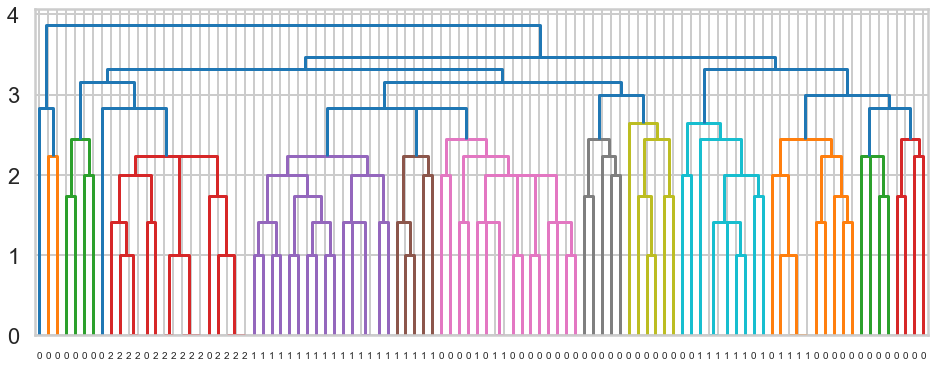

In [372]:
mergings = linkage(x_cols, method='complete')
# Plot the dendrogram, using labels_kmeans as labels
f, ax = plt.subplots(figsize=(16,6))
dendrogram(mergings,
           labels=labels_kmeans,
           leaf_rotation=0, leaf_font_size=10)
plt.show()

Hierarchical clustering differs from KMeans.

### DBSCAN
https://scikit-learn.org/stable/modules/clustering.html#dbscan

<i>Core sample</i>: there exist `min_samples` other neighbors within a distance of `eps`. A <i>cluster</i> is a set of core samples that can be built by recursively taking a core sample, finding all of its neighbors that are core samples, finding all of <i>their</i> neighbors that are core samples, and so on. A cluster also has a set of non-core samples on the fringes, which are samples that are neighbors of a core sample in the cluster but are not themselves core samples.

`eps` is too small: no clusters, too large: causes close clusters to be merged.

In [463]:
from sklearn.cluster import DBSCAN
#from sklearn import metrics
from sklearn.preprocessing import StandardScaler
x_scaled = StandardScaler().fit_transform(x_cols)

In [457]:
# optimization of `epsilon`
silhouette_DBSCAN = list([])
silhouette_max=-1
eps_vals = list([])
for ep in np.arange(0.1, 100.1, 0.1):
    db = DBSCAN(eps=ep, min_samples=2).fit(x_scaled)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels_DBSCAN = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels_DBSCAN)) - (1 if -1 in labels_DBSCAN else 0)
    if n_clusters_ > 1:
        n_noise_ = list(labels_DBSCAN).count(-1)

        labels_true = labels_kmeans
        silhouette = metrics.silhouette_score(x_scaled, labels_DBSCAN)
        eps_vals.append(ep)
        silhouette_DBSCAN.append(silhouette)
        if silhouette > silhouette_max:
            silhouette_max = silhouette
            ep_max = ep
print(silhouette_DBSCAN)
print("Optimal epsilon =",ep_max)
print("Optimal silhouette score =",silhouette_max)

[-0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, -0.04683327287920104, 0.02561071416727757, 0.03341648805705359, 0.04356896255645473, 0.04356896255645473, 0.03593871790461838, 0.03593871790461838, 0.03923764075825858, 0.03923764075825858, 0.03923764075825858, 0.010602106230866146, 0.030569995743415665, 0.028659132185812824, 0.02054418479662529, -0.005204658043442629, 0.043822083208896995, 0.052432576351943545, 0.052432576351943545, 0.052432576351943545, 0.06397998280166618, 0.06547041580233018, 0.06547041580233018, 0.0684596730935041, 0

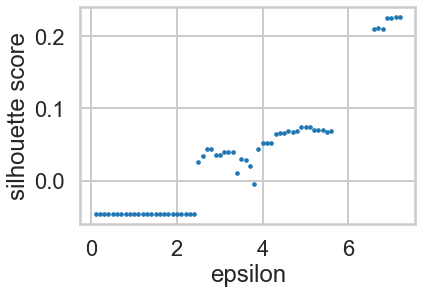

In [462]:
plt.scatter(eps_vals, silhouette_DBSCAN, s=7);
plt.xlabel('epsilon');
plt.ylabel('silhouette score');

In [472]:
np.arange(1, 11)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [490]:
del(silhouette_DBSCAN)

In [492]:
# optimization of `min_samples`
silhouette_DBSCAN = list([])
silhouette_max=-1
min_samples_vals = list([])
for min_samples in range(1, 101):
    db = DBSCAN(eps=7.1, min_samples=min_samples).fit(x_scaled)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels_DBSCAN = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels_DBSCAN)) - (1 if -1 in labels_DBSCAN else 0)
    if n_clusters_ >= 1:
        n_noise_ = list(labels_DBSCAN).count(-1)

        labels_true = labels_kmeans
        silhouette = metrics.silhouette_score(x_scaled, labels_DBSCAN)
        min_samples_vals.append(min_samples)
        silhouette_DBSCAN.append(silhouette)
        if silhouette > silhouette_max:
            silhouette_max = silhouette
            min_samples_max = min_samples
print(silhouette_DBSCAN)
print("Optimal min_samples =",min_samples_max)
print("Optimal silhouette score =",silhouette_max)

[0.14974117231000642, 0.22705565656854673, 0.22705565656854673, 0.24654389350121625, 0.24654389350121625, 0.24654389350121625, 0.24654389350121625, 0.24654389350121625, 0.24654389350121625, 0.24654389350121625, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.24821027387149858, 0.2458348877462479, 0.2458348877462479, 0.245834887746

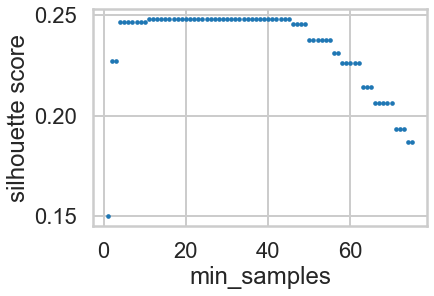

In [494]:
plt.scatter(min_samples_vals, silhouette_DBSCAN, s=7);
plt.xlabel('min_samples');
plt.ylabel('silhouette score');

#### Best found parameters

In [496]:
db = DBSCAN(eps=7.1, min_samples=11).fit(x_scaled)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_DBSCAN = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_DBSCAN)) - (1 if -1 in labels_DBSCAN else 0)
n_noise_ = list(labels_DBSCAN).count(-1)

labels_true = labels_kmeans
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels_DBSCAN))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels_DBSCAN))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels_DBSCAN))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels_DBSCAN))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels_DBSCAN)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(x_scaled, labels_DBSCAN))
labels_DBSCAN

Estimated number of noise points: 10
Homogeneity: 0.043
Completeness: 0.129
V-measure: 0.064
Adjusted Rand Index: -0.040
Adjusted Mutual Information: 0.048
Silhouette Coefficient: 0.248


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      dtype=int64)

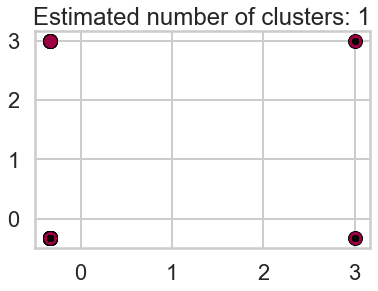

In [497]:
# Plot result
#import matplotlib.pyplot as plt
X = x_scaled
# Black removed and is used for noise instead.
unique_labels = set(labels_DBSCAN)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels_DBSCAN == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

<font color=red><b>Q7 How to read this plot?</b></font>

### Conclusion
Using silhouette score, the above clustering models can be ranked from worst to best as follows:

K-Means Clustering (0.139), Affinity Propagation (0.180), DBSCAN (0.248).

<font color=red><b>Q8 Are there silhouette scores for Spectral Clustreing and for Agglomerative Clustering?</b></font>